In [1]:
import pandas as pd
data = pd.read_csv ('twitter_training.csv').fillna('')

In [2]:
my_df = data
my_df.head(5)

,no,name,sentimen,text
0,2401,Borderlands,1,im getting on borderlands and i will murder yo...
1,2401,Borderlands,1,I am coming to the borders and I will kill you...
2,2401,Borderlands,1,im getting on borderlands and i will kill you ...
3,2401,Borderlands,1,im coming on borderlands and i will murder you...
4,2401,Borderlands,1,im getting on borderlands 2 and i will murder ...


In [3]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   no        74682 non-null  int64 
 1   name      74682 non-null  object
 2   sentimen  74682 non-null  object
 3   text      74682 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
x = my_df.text
y = my_df.sentimen

In [5]:
import sklearn

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

In [7]:
print("Train set has total {0} entries:".format(len(x_train)))
print("  {0:.2f}% Neutral".format((len(x_train[y_train == '2']) / (len(x_train)*1.))*100))
print("  {0:.2f}% Positive".format((len(x_train[y_train == '1']) / (len(x_train)*1.))*100))
print("  {0:.2f}% Negative".format((len(x_train[y_train == '0']) / (len(x_train)*1.))*100))
print("  {0:.2f}% Irrelevant".format((len(x_train[y_train == 'Irrelevant']) / (len(x_train)*1.))*100))

Train set has total 59745 entries:
  30.15% Neutral
  28.00% Positive
  24.45% Negative
  17.40% Irrelevant


In [8]:
print("Test set has total {0} entries:".format(len(x_test)))
print("  {0:.2f}% Neutral".format((len(x_test[y_test == '2']) / (len(x_test)*1.))*100))
print("  {0:.2f}% Positive".format((len(x_test[y_test == '1']) / (len(x_test)*1.))*100))
print("  {0:.2f}% Negative".format((len(x_test[y_test == '0']) / (len(x_test)*1.))*100))
print("  {0:.2f}% Irrelevant".format((len(x_test[y_test == 'Irrelevant']) / (len(x_test)*1.))*100))

Test set has total 14937 entries:
  30.32% Neutral
  27.46% Positive
  24.85% Negative
  17.37% Irrelevant


In [9]:
!pip install gensim
from tqdm import tqdm
tqdm.pandas (desc = "progress-bar")

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument

import multiprocessing
from sklearn import utils

In [10]:
def labelize_tweets_ug(tweets,label):
  result = []
  prefix = label
  for i, t in zip(tweets.index, tweets):
    result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
  return result

In [11]:
all_x = pd.concat([x_train, x_test]).fillna('')
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [12]:
all_x_w2v[:5]

[TaggedDocument(words=['Just', 'listened', 'to', "Jagr's", 'interview,', 'shit', 'is', 'scary.'], tags=['all_2816']),
 TaggedDocument(words=['Fifa', 'players', 'in', '2016', '"', 'we', 'have', 'all', 'these', 'useless', 'cards', 'in', 'our', 'clubs', 'that', 'nobody', 'will', 'buy', '"..', 'Ea', '2018', '"', "here's", 'repeatable', "sbc'h", 's', 'so', 'you', 'players', 'can', 'legally', 'grind', 'cards', 'up', 'to', 'top', 'level', 'squads', 'without', 'spending', 'money', '"..', 'Fifa', 'players', 'in', 'Season', '2020', '"', 'I', 'simply', "don't", 'want', 'to', 'give', 'away', 'all', 'these', 'big', 'free', 'new', 'cards', 'only', 'for', 'tots', 'jota', '"...'], tags=['all_49288']),
 TaggedDocument(words=['I', 'am', 'so', 'few', 'facebook', 'friends', 'but', 'I', 'still', 'love', 'smashing', 'that', 'unfollow', 'symbol', 'when', 'one', 'surprise-shares', 'a', 'ron', 'paul', 'video'], tags=['all_58695']),
 TaggedDocument(words=['Anyone', 'who', 'plays', 'call', 'letters', 'of', 'duty

In [13]:
model_ug_sg = Word2Vec(sg=1,  negative=5, window=2, min_count=2, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 74682/74682 [00:00<00:00, 1450415.63it/s]


In [14]:
%%time
for epoch in range(30):
  model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples = len(all_x_w2v), epochs =1)
  model_ug_sg.alpha -= 0.002
  model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 74682/74682 [00:00<00:00, 3179800.95it/s]


CPU times: user 3min 28s, sys: 864 ms, total: 3min 29s
Wall time: 2min 10s


In [15]:
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [16]:
from gensim.models import KeyedVectors
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [17]:
embeddings_index = {}
for w in model_ug_sg.wv.index_to_key:
  embeddings_index[w] = model_ug_sg.wv[w]
print('Found %s word vectors.' % len(embeddings_index))

Found 51830 word vectors.


In [18]:
embeddings_index['film']

array([-1.07660329e+00, -1.72598332e-01, -4.63439018e-01, -4.72645670e-01,
        1.29520208e-01, -8.47930014e-01, -4.65762950e-02,  2.08806276e-01,
       -4.41896543e-02, -2.85292813e-03,  4.08852160e-01, -4.67449278e-02,
       -3.59232634e-01, -3.27501923e-01, -1.47559000e-02, -2.44280741e-01,
        1.10308975e-01, -6.13648482e-02,  5.34288526e-01, -1.49884009e+00,
       -1.67699978e-01, -4.44652647e-01, -5.24676681e-01,  4.76121068e-01,
       -6.52565479e-01, -4.48484659e-01, -6.48337364e-01,  7.55446404e-02,
       -2.25215122e-01, -2.81904191e-01, -2.87343293e-01,  4.80929464e-01,
        3.26485872e-01, -4.91852790e-01,  4.93357271e-01,  4.17696059e-01,
        5.45531094e-01, -6.11002564e-01, -5.74326515e-01,  1.54776171e-01,
        6.32336140e-01, -4.71917301e-01,  2.06013381e-01,  2.74607837e-01,
       -2.01006323e-01, -8.59770000e-01, -9.71601382e-02,  3.77922989e-02,
       -5.80653548e-01, -4.59358037e-01,  2.68285513e-01,  7.69500108e-03,
       -3.06051672e-01,  

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [25]:
len(tokenizer.word_index)

32246

In [26]:
for x in x_train[:5]:
  print (x)

Just listened to Jagr's interview, shit is scary.
Fifa players in 2016 " we have all these useless cards in our clubs that nobody will buy ".. Ea 2018 " here's repeatable sbc'h s so you players can legally grind cards up to top level squads without spending money ".. Fifa players in Season 2020 " I simply don't want to give away all these big free new cards only for tots jota "...
I am so few facebook friends but I still love smashing that unfollow symbol when one surprise-shares a ron paul video
Anyone who plays call letters of duty right with the bitch made @kyle_nusio6 is getting deleted from my friends list, hes been on black listed both for ditching all the little boys on numerous rare occasions and gets carried in on every match.
@Pinkwardlol get so damned mad you lost that game because of CSGO after you banned me from your life Twitch i'm weakkk


In [27]:
sequences[:5]

[[23, 4255, 3, 3258, 72, 7, 1550],
 [118,
  227,
  9,
  1189,
  39,
  22,
  27,
  131,
  1691,
  589,
  9,
  110,
  2860,
  15,
  1246,
  52,
  233,
  367,
  1427,
  1034,
  116,
  19,
  12,
  227,
  49,
  1639,
  589,
  55,
  3,
  284,
  566,
  2932,
  402,
  1869,
  251,
  118,
  227,
  9,
  329,
  151,
  2,
  1011,
  120,
  147,
  3,
  264,
  441,
  27,
  131,
  223,
  243,
  57,
  589,
  105,
  8,
  7174,
  5017],
 [2,
  119,
  19,
  368,
  79,
  351,
  25,
  2,
  78,
  58,
  6201,
  15,
  6640,
  5550,
  54,
  44,
  1488,
  2319,
  5,
  5551,
  2933,
  153],
 [349,
  89,
  832,
  155,
  8365,
  6,
  215,
  168,
  17,
  1,
  632,
  220,
  6641,
  9092,
  7,
  173,
  1190,
  33,
  14,
  351,
  570,
  2624,
  77,
  13,
  202,
  4451,
  314,
  8,
  27,
  1,
  338,
  960,
  13,
  3259,
  3194,
  5855,
  4,
  442,
  3128,
  9,
  13,
  163,
  483],
 [9093,
  38,
  19,
  1571,
  599,
  12,
  382,
  15,
  18,
  91,
  6,
  219,
  115,
  12,
  377,
  21,
  33,
  34,
  256,
  134,
  59]]

In [28]:
length = []
for x in x_train:
  length.append(len(x.split()))

In [29]:
max(length)

198

In [30]:
x_train_seq = pad_sequences(sequences, maxlen = 55)
print('SHape of data tensor:', x_train_seq.shape)

SHape of data tensor: (59745, 55)


In [31]:
x_train_seq[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   23, 4255,    3, 3258,   72,    7, 1550],
       [   9, 1189,   39,   22,   27,  131, 1691,  589,    9,  110, 2860,
          15, 1246,   52,  233,  367, 1427, 1034,  116,   19,   12,  227,
          49, 1639,  589,   55,    3,  284,  566, 2932,  402, 1869,  251,
         118,  227,    9,  329,  151,    2, 1011,  120,  147,    3,  264,
         441,   27,  131,  223,  243,   57,  589,  105,    8, 7174, 5017],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           2,  119,   19,  368,   79

In [32]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=55)

In [34]:
import numpy as np

num_words = 10000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
  if i >= num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    # print(word) # Optional: uncomment to see which words are found

In [37]:
np.array_equal(embedding_matrix[1], embeddings_index.get('film'))

False

In [39]:
seed = 7

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

In [44]:
# Filter out 'Neutral' and 'Irrelevant' sentiments for binary classification
y_train_binary = y_train[(y_train == '1') | (y_train == '0')]
x_train_binary = x_train[y_train_binary.index]

y_test_binary = y_test[(y_test == '1') | (y_test == '0')]
x_test_binary = x_test[y_test_binary.index]

# Convert string labels to numerical labels (1 for Positive, 0 for Negative)
y_train_seq = y_train_binary.apply(lambda x: 1 if x == '1' else 0)
y_test_seq = y_test_binary.apply(lambda x: 1 if x == '1' else 0)

print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of y_train_seq: (31337,)
Shape of y_test_seq: (7813,)


In [47]:
# Tokenize and pad the binary data
x_train_binary_seq = tokenizer.texts_to_sequences(x_train_binary)
x_test_binary_seq = tokenizer.texts_to_sequences(x_test_binary)

x_train_binary_padded = pad_sequences(x_train_binary_seq, maxlen=55)
x_test_binary_padded = pad_sequences(x_test_binary_seq, maxlen=55)


model_ptw2v = Sequential()
e = Embedding(10000, 200)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation = 'relu'))
model_ptw2v.add(Dense(1, activation = 'sigmoid'))
model_ptw2v.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_ptw2v.fit(x_train_binary_padded, y_train_seq, validation_data = (x_test_binary_padded, y_test_seq), epochs = 5, batch_size = 32, verbose = 2)

Epoch 1/5
980/980 - 43s - 44ms/step - accuracy: 0.8205 - loss: 0.3751 - val_accuracy: 0.9036 - val_loss: 0.2257
Epoch 2/5
980/980 - 79s - 80ms/step - accuracy: 0.9544 - loss: 0.1031 - val_accuracy: 0.9076 - val_loss: 0.2484
Epoch 3/5
980/980 - 42s - 43ms/step - accuracy: 0.9701 - loss: 0.0623 - val_accuracy: 0.9067 - val_loss: 0.2949
Epoch 4/5
980/980 - 80s - 81ms/step - accuracy: 0.9724 - loss: 0.0530 - val_accuracy: 0.9017 - val_loss: 0.3262
Epoch 5/5
980/980 - 37s - 38ms/step - accuracy: 0.9726 - loss: 0.0550 - val_accuracy: 0.8956 - val_loss: 0.3534


In [49]:
model_ptw2v = Sequential()
e = Embedding(10000, 100, weights = [embedding_matrix], trainable = True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation = 'relu'))
model_ptw2v.add(Dense(1, activation = 'sigmoid'))
model_ptw2v.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_ptw2v.fit(x_train_binary_padded, y_train_seq, validation_data = (x_test_binary_padded, y_test_seq), epochs = 5, batch_size = 32, verbose = 2)

Epoch 1/5
980/980 - 25s - 25ms/step - accuracy: 0.7700 - loss: 0.4719 - val_accuracy: 0.8383 - val_loss: 0.3604
Epoch 2/5
980/980 - 22s - 22ms/step - accuracy: 0.9227 - loss: 0.1872 - val_accuracy: 0.8844 - val_loss: 0.2868
Epoch 3/5
980/980 - 22s - 23ms/step - accuracy: 0.9698 - loss: 0.0682 - val_accuracy: 0.8931 - val_loss: 0.3177
Epoch 4/5
980/980 - 39s - 40ms/step - accuracy: 0.9769 - loss: 0.0463 - val_accuracy: 0.8920 - val_loss: 0.3535
Epoch 5/5
980/980 - 22s - 23ms/step - accuracy: 0.9772 - loss: 0.0441 - val_accuracy: 0.8853 - val_loss: 0.4110


In [51]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

In [53]:
# lr=0,0001 dan dropout=0,2
from tensorflow.keras.layers import Input, Dense, concatenate, Activation, Conv1D, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tweet_input = Input(shape = (55,), dtype = 'int32')

tweet_encode = Embedding(10000, 200) (tweet_input)
bigram_branch = Conv1D(filters = 100, kernel_size = 2, padding = 'valid', activation = 'relu', strides = 1) (tweet_encode)
bigram_branch = GlobalMaxPooling1D() (bigram_branch)
trigram_branch = Conv1D(filters = 100, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1) (tweet_encode)
trigram_branch = GlobalMaxPooling1D() (trigram_branch)
fourgram_branch = Conv1D(filters = 100, kernel_size = 4, padding = 'valid', activation = 'relu', strides = 1) (tweet_encode)
fourgram_branch = GlobalMaxPooling1D() (fourgram_branch)

merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis = -1)
merged = Dense(256, activation = 'relu') (merged)
merged = Dropout(0.2) (merged)
merged = Dense(1) (merged)
output = Activation('sigmoid') (merged)
opt = Adam(learning_rate = 0.0001)
model = Model(inputs = [tweet_input], outputs = [output])

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 55)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 55, 200)   │  2,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 54, 100)   │     40,100 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 53, 100)   │     60,100 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 52, 100)   │     80,100 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 300)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     77,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ dense_13[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,257,613 (8.61 MB)

 Trainable params: 2,257,613 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

# Define the K-Fold Splitter
kf = KFold(n_splits=5, shuffle=True, random_state=seed) # Using 5 splits as an example, adjust if needed

fold_no = 1
for train_index, test_index in kf.split (x_train_binary_padded, y_train_seq):
  print('-----------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  x_tr, x_te = x_train_binary_padded[train_index], x_train_binary_padded[test_index]
  y_tr, y_te = y_train_seq.iloc[train_index], y_train_seq.iloc[test_index] # Use .iloc for pandas Series

  model.fit(x_tr, y_tr, batch_size = 32, epochs = 5, validation_data = (x_te, y_te), callbacks = [checkpoint])
  fold_no = fold_no + 1

-----------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
783/784 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6203 - loss: 0.6523
Epoch 1: val_accuracy improved from -inf to 0.78590, saving model to CNN_best_weights.01-0.7859.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6204 - loss: 0.6521 - val_accuracy: 0.7859 - val_loss: 0.4696
Epoch 2/5
783/784 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8322 - loss: 0.3937
Epoch 2: val_accuracy improved from 0.78590 to 0.86487, saving model to CNN_best_weights.02-0.8649.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.8323 - loss: 0.3936 - val_accuracy: 0.8649 - val_loss: 0.3194
Epoch 3/5
784/784 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9221 - loss: 0.2125
Epoch 3: val_accuracy improved from 0.86487 to 0.90491, saving model to CNN_best_weights.03-0.9049.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9221 - loss: 0.2124 - val_accurac

In [59]:
from tensorflow.keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.01-0.9824.keras')
loaded_CNN_model.evaluate(x = x_test_binary_padded, y = y_test_seq)

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9384 - loss: 0.1738


[0.17402423918247223, 0.9395878911018372]

In [60]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen = 55)

In [62]:
#load CNN model
loaded_CNN_model.evaluate(x = x_test_binary_padded, y = y_test_seq)

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9384 - loss: 0.1738


[0.17402423918247223, 0.9395878911018372]

In [66]:
y_temp_binary = loaded_CNN_model.predict(x_test_binary_padded)
yhat_cnn_binary = []
for i in range(0, len(y_temp_binary)):
  if (y_temp_binary[i] > 1-y_temp_binary[i]):
    yhat_cnn_binary.append(1)
  else:
    yhat_cnn_binary.append(0)
print(yhat_cnn_binary)

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_seq, yhat_cnn_binary)

array([[3495,  217],
       [ 255, 3846]])

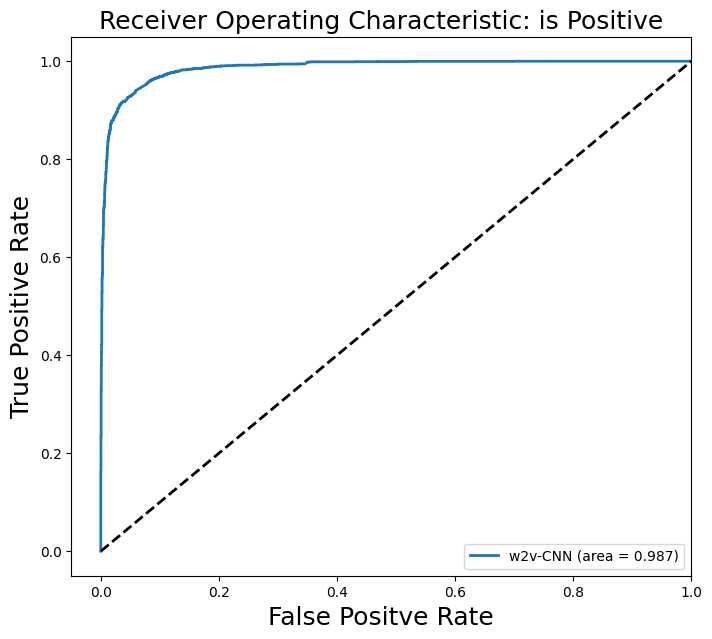

In [69]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_cnn, tpr_cnn, threshold = roc_curve(y_test_seq, y_temp_binary)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize = (8,7))
plt.plot(fpr_cnn, tpr_cnn, label = 'w2v-CNN (area = %0.3f)' % roc_auc_cnn, linewidth = 2)

plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positve Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Receiver Operating Characteristic: is Positive', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

### Evaluation of the model without pre-trained embeddings
First, let's make predictions using the model trained in cell `hEyDhphOuTi1` (the model without pre-trained embeddings) on the binary test set (`x_test_binary_padded`).

In [70]:
# Make predictions with the model without pre-trained embeddings
y_temp_no_pretrained = model_ptw2v.predict(x_test_binary_padded)
yhat_no_pretrained = (y_temp_no_pretrained > 0.5).astype("int32")

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Now, let's calculate and display the confusion matrix for this model.

In [71]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix for model without pre-trained embeddings:")
print(confusion_matrix(y_test_seq, yhat_no_pretrained))

Confusion Matrix for model without pre-trained embeddings:
[[3195  517]
 [ 379 3722]]


Finally, let's calculate and plot the ROC curve for this model.

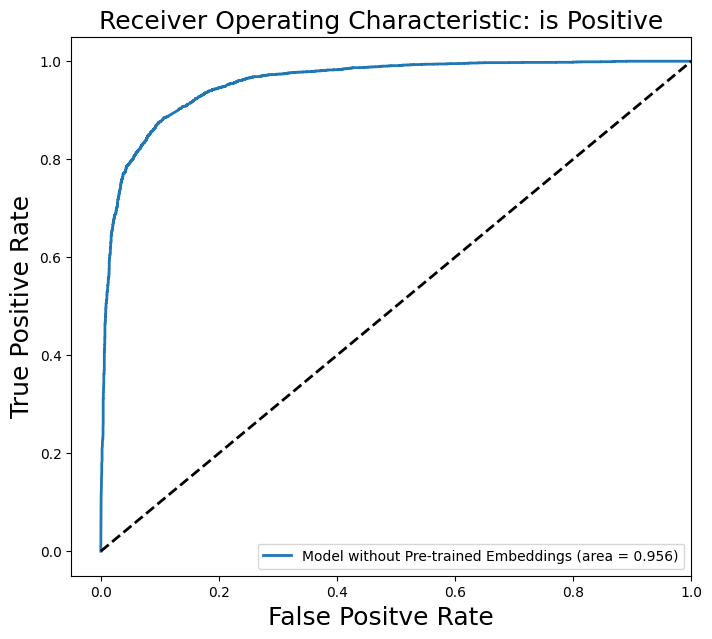

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_no_pretrained, tpr_no_pretrained, threshold = roc_curve(y_test_seq, y_temp_no_pretrained)
roc_auc_no_pretrained = auc(fpr_no_pretrained, tpr_no_pretrained)

plt.figure(figsize = (8,7))
plt.plot(fpr_no_pretrained, tpr_no_pretrained, label = 'Model without Pre-trained Embeddings (area = %0.3f)' % roc_auc_no_pretrained, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positve Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Receiver Operating Characteristic: is Positive', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

### Evaluation of the model with pre-trained embeddings
Now, let's evaluate the performance of the model trained in cell `8EkFLxznuTsx` (the model with pre-trained embeddings) on the binary test set (`x_test_binary_padded`).

First, we make predictions using this model.

In [73]:
# Make predictions with the model with pre-trained embeddings
# Note: The model trained in cell 8EkFLxznuTsx was also assigned to model_ptw2v
# We need to ensure we are using the correct model instance if both were assigned to the same variable name.
# Assuming the last assigned model to model_ptw2v is the one from cell 8EkFLxznuTsx, we will use it.
y_temp_with_pretrained = model_ptw2v.predict(x_test_binary_padded)
yhat_with_pretrained = (y_temp_with_pretrained > 0.5).astype("int32")

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Now, let's calculate and display the confusion matrix for this model.

In [74]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix for model with pre-trained embeddings:")
print(confusion_matrix(y_test_seq, yhat_with_pretrained))

Confusion Matrix for model with pre-trained embeddings:
[[3195  517]
 [ 379 3722]]


Finally, let's calculate and plot the ROC curve for this model.

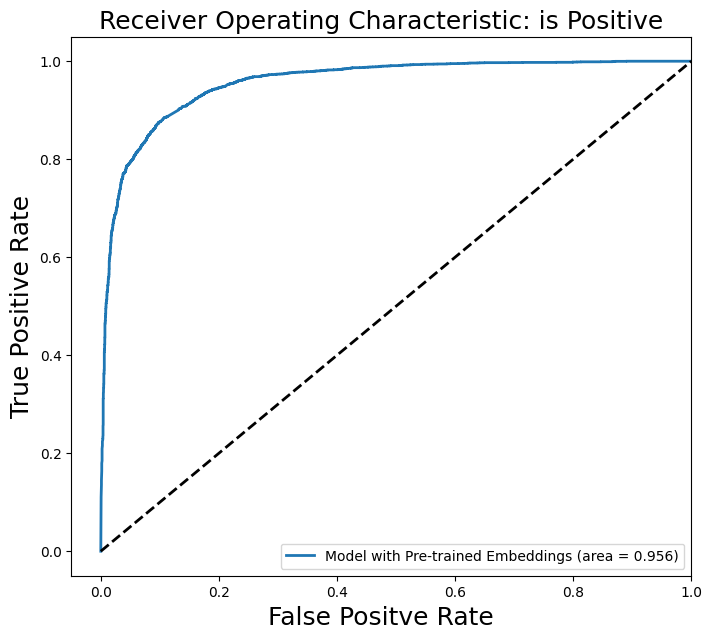

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_with_pretrained, tpr_with_pretrained, threshold = roc_curve(y_test_seq, y_temp_with_pretrained)
roc_auc_with_pretrained = auc(fpr_with_pretrained, tpr_with_pretrained)

plt.figure(figsize = (8,7))
plt.plot(fpr_with_pretrained, tpr_with_pretrained, label = 'Model with Pre-trained Embeddings (area = %0.3f)' % roc_auc_with_pretrained, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positve Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Receiver Operating Characteristic: is Positive', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

In [77]:
fpr_cnn, tpr_cnn, roc_auc_cnn

(array([0.        , 0.        , 0.        , ..., 0.99380388, 0.99461207,
        1.        ]),
 array([0.        , 0.00219459, 0.0034138 , ..., 1.        , 1.        ,
        1.        ]),
 0.9865793088733614)

In [78]:
y_test, y_temp, yhat_cnn, y_temp.shape

(26144    1
 64273    2
 19641    0
 44123    2
 62707    2
         ..
 35465    1
 59882    0
 24250    0
 74315    1
 44709    1
 Name: sentimen, Length: 14937, dtype: object,
 array([[9.9990100e-01],
        [3.4559187e-02],
        [5.3002627e-06],
        ...,
        [1.3508406e-05],
        [9.9977529e-01],
        [9.9816340e-01]], dtype=float32),
 [1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
 

In [80]:
def predict_sentiment_binary(sentence):
  """
  Predicts the sentiment of a single sentence using the loaded binary CNN model.

  Args:
    sentence: The input sentence string.

  Returns:
    'Positive' or 'Negative' based on the model's prediction.
    Note: This model is a binary classifier and cannot directly predict 'Neutral' or 'Irrelevant'.
  """
  # Preprocess the sentence
  # Tokenize
  sequence = tokenizer.texts_to_sequences([sentence])
  # Pad
  padded_sequence = pad_sequences(sequence, maxlen=55)

  # Make prediction using the loaded CNN model (binary)
  prediction = loaded_CNN_model.predict(padded_sequence)

  # Interpret the prediction (sigmoid output is probability of positive class)
  if prediction[0][0] > 0.5:
    return 'Positive'
  else:
    return 'Negative'

# Example usage:
test_sentence = "This is a great product!"
predicted_sentiment = predict_sentiment_binary(test_sentence)
print(f"The sentiment of the sentence '{test_sentence}' is: {predicted_sentiment}")

test_sentence_negative = "I am very disappointed with the service."
predicted_sentiment_negative = predict_sentiment_binary(test_sentence_negative)
print(f"The sentiment of the sentence '{test_sentence_negative}' is: {predicted_sentiment_negative}")

test_sentence_neutral = "The weather is cloudy today."
predicted_sentiment_neutral = predict_sentiment_binary(test_sentence_neutral)
print(f"The sentiment of the sentence '{test_sentence_neutral}' is: {predicted_sentiment_neutral} (Note: Model is binary)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The sentiment of the sentence 'This is a great product!' is: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The sentiment of the sentence 'I am very disappointed with the service.' is: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The sentiment of the sentence 'The weather is cloudy today.' is: Positive (Note: Model is binary)
